In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"praveenkhola","key":"9c81709f1a481c38f253f233b0d4cbb2"}'}

In [2]:
# Make directory named kaggle and copy kaggle.json file there.
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets list

ref                                                              title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
carlmcbrideellis/llm-7-prompt-training-dataset                   LLM: 7 prompt training dataset                     41MB  2023-11-15 07:32:56            992         86  1.0              
thedrcat/daigt-v2-train-dataset                                  DAIGT V2 Train Dataset                             29MB  2023-11-16 01:38:36            486         73  1.0              
muhammadbinimran/housing-price-prediction-data                   Housing Price Prediction Data                     763KB  2023-11-21 17:56:32            990         22  1.0              
thedrcat/daigt-proper-train-dataset                              

In [46]:
!kaggle datasets download -d yasserh/imdb-movie-ratings-sentiment-analysis

 44% 9.00M/20.6M [00:00<00:00, 45.8MB/s]
100% 20.6M/20.6M [00:00<00:00, 88.1MB/s]


### Unzip the data

In [47]:
import zipfile
zip_ref = zipfile.ZipFile('/content/imdb-movie-ratings-sentiment-analysis.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

### Importing the neccessities

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [49]:
data_df = pd.read_csv("/content/movie.csv")
data_df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [51]:
data_df["label"].value_counts()

0    20019
1    19981
Name: label, dtype: int64

In [53]:
list(data_df[data_df["label"]==0]["text"][:2])

['I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.',
 "When I put this movie in my DVD player, and sat down with a coke and some chips, I had some expectations. I was hoping 

In [54]:
list(data_df[data_df["label"]==1]["text"][:2])

['Im a die hard Dads Army fan and nothing will ever change that. I got all the tapes, DVD\'s and audiobooks and every time i watch/listen to them its brand new. <br /><br />The film. The film is a re run of certain episodes, Man and the hour, Enemy within the gates, Battle School and numerous others with a different edge. Introduction of a new General instead of Captain Square was a brilliant move - especially when he wouldn\'t cash the cheque (something that is rarely done now).<br /><br />It follows through the early years of getting equipment and uniforms, starting up and training. All in all, its a great film for a boring Sunday afternoon. <br /><br />Two draw backs. One is the Germans bogus dodgy accents (come one, Germans cant pronounced the letter "W" like us) and Two The casting of Liz Frazer instead of the familiar Janet Davis. I like Liz in other films like the carry ons but she doesn\'t carry it correctly in this and Janet Davis would have been the better choice.',
 'Finally

### Cleaning the data

In [55]:
import re
import string
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [56]:
data_df["text"] = data_df["text"].apply(lambda x: clean_text(x))
data_df.head()

,text,label
0,i grew up b watching and loving the thunderbi...,0
1,when i put this movie in my dvd player and sat...,0
2,why do people who do not know what a particula...,0
3,even though i have great interest in biblical ...,0
4,im a die hard dads army fan and nothing will e...,1


# Random shuffle the data to mix the samples of the two classes perfectly

In [57]:
data_df_shuffled = data_df.sample(frac=1,random_state=20)
data_df_shuffled.head()

,text,label
5406,slasherswell if you like horrors its definitel...,0
29810,based on elmore leonard this is a violent and ...,1
9966,this is the fourth fulllength feature film by ...,1
27442,famous movies are subject to freudian analysis...,1
8522,as a former submariner this was one of the wor...,0


### Sorting based on target variable

In [58]:
data_pos = data_df_shuffled[data_df_shuffled['label'] == 1]
data_neg = data_df_shuffled[data_df_shuffled['label'] == 0] #Separating positive and negative and neutral tweets
dataset = pd.concat([data_pos, data_neg])
dataset.shape

(40000, 2)

In [59]:
dataset.head()

,text,label
29810,based on elmore leonard this is a violent and ...,1
9966,this is the fourth fulllength feature film by ...,1
27442,famous movies are subject to freudian analysis...,1
28499,this is a very dark movie somewhat better than...,1
20134,anybody who goes to the manhattan hospital cen...,1


### Removing stopwords from the text

In [60]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [61]:
# Removing stopwords
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

29810    based elmore leonard violent intelligent actio...
9966     fourth fulllength feature film marc recha thir...
27442    famous movies subject freudian analysis posses...
28499    dark movie somewhat better average asylum film...
20134    anybody goes manhattan hospital center taking ...
Name: text, dtype: object

### Removing repeating characters

In [62]:
# Removing repeating characters
import re
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

26394    must good mood give shameful predictable embar...
21973    admittedly reason watched film since decade si...
22294    take scifi original movie mix little alternati...
23775    jefferey dahmer one sick guy theres not much s...
37135    unfortunately showing star movies thailand las...
Name: text, dtype: object

### Tokenizing the text data

In [63]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer('\s+', gaps = True)
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)

In [64]:
dataset['text'].head()

29810    [based, elmore, leonard, violent, intelligent,...
9966     [fourth, fulllength, feature, film, marc, rech...
27442    [famous, movies, subject, freudian, analysis, ...
28499    [dark, movie, somewhat, better, average, asylu...
20134    [anybody, goes, manhattan, hospital, center, t...
Name: text, dtype: object

### Stemming the text data

In [65]:
import nltk
from functools import lru_cache
st = nltk.PorterStemmer()
stem = lru_cache(maxsize=50000)(st.stem)
def stemming_on_text(data):
    text = [stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

29810    [based, elmore, leonard, violent, intelligent,...
9966     [fourth, fulllength, feature, film, marc, rech...
27442    [famous, movies, subject, freudian, analysis, ...
28499    [dark, movie, somewhat, better, average, asylu...
20134    [anybody, goes, manhattan, hospital, center, t...
Name: text, dtype: object

### Applying lemmatizer

In [66]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [67]:
lm = nltk.WordNetLemmatizer()
lemmatize = lru_cache(maxsize=50000)(lm.lemmatize)
def lemmatizer_on_text(data):
    text = [lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

29810    [based, elmore, leonard, violent, intelligent,...
9966     [fourth, fulllength, feature, film, marc, rech...
27442    [famous, movies, subject, freudian, analysis, ...
28499    [dark, movie, somewhat, better, average, asylu...
20134    [anybody, goes, manhattan, hospital, center, t...
Name: text, dtype: object

In [68]:
dataset.head()

,text,label
29810,"[based, elmore, leonard, violent, intelligent,...",1
9966,"[fourth, fulllength, feature, film, marc, rech...",1
27442,"[famous, movies, subject, freudian, analysis, ...",1
28499,"[dark, movie, somewhat, better, average, asylu...",1
20134,"[anybody, goes, manhattan, hospital, center, t...",1


### WordCloud for negative sentiment

(-0.5, 1599.5, 799.5, -0.5)

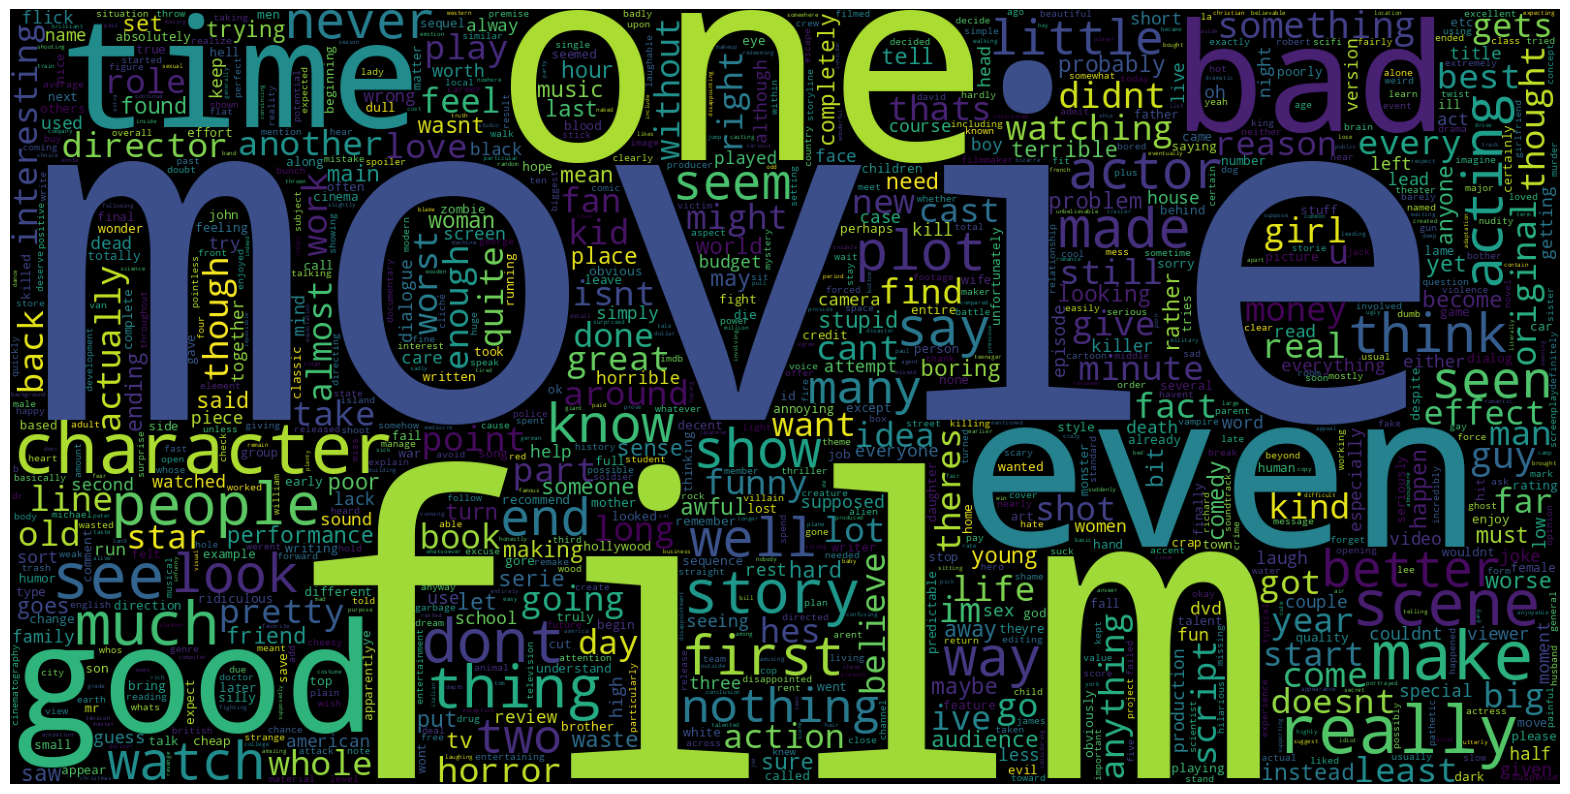

In [70]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
data_neg = dataset[dataset['label']==0]['text'].apply(lambda x: ' '.join(x) )
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)
plt.axis('off')

### WordCloud for positive words

(-0.5, 1599.5, 799.5, -0.5)

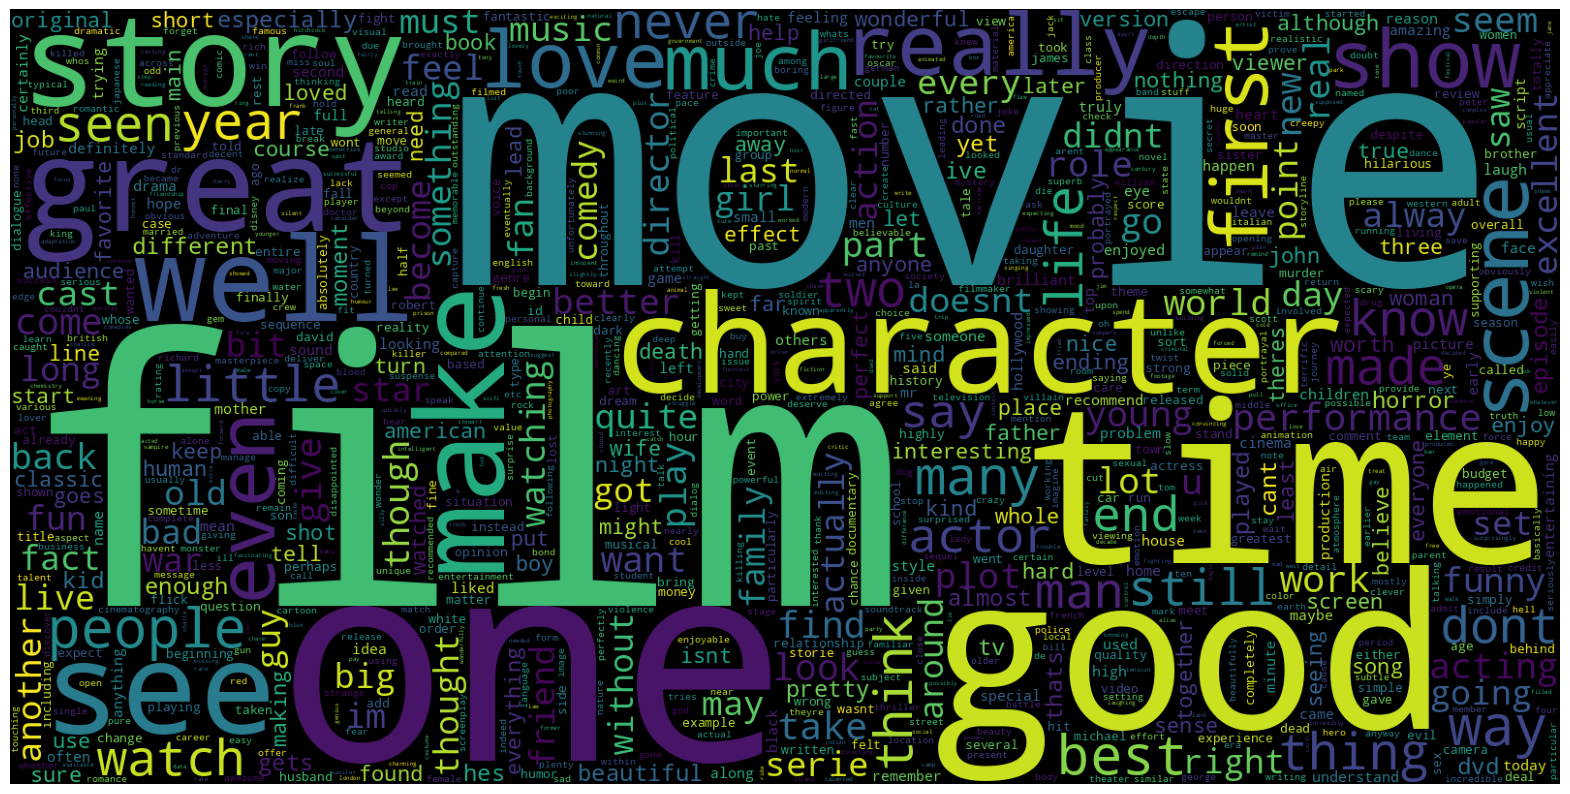

In [71]:
data_pos = dataset[dataset['label']==1]['text'].apply(lambda x: ' '.join(x) )
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)
plt.axis('off')

In [72]:
words = set()
for data in dataset['text']:
    for word in data:
        words.add(word)

len(words)

186289

### Rejoining the tokens to a sentence format

In [73]:
new_data=dataset
new_data['text'] = dataset['text'].apply(lambda x: ' '.join(x) )
new_data.head()

,text,label
29810,based elmore leonard violent intelligent actio...,1
9966,fourth fulllength feature film marc recha thir...,1
27442,famous movies subject freudian analysis posses...,1
28499,dark movie somewhat better average asylum film...,1
20134,anybody goes manhattan hospital center taking ...,1


In [74]:
new_data.tail()

,text,label
26394,must good mood give shameful predictable embar...,0
21973,admittedly reason watched film since decade si...,0
22294,take scifi original movie mix little alternati...,0
23775,jefferey dahmer one sick guy theres not much s...,0
37135,unfortunately showing star movies thailand las...,0


## Split data into train and validation sets

In [75]:
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)
train_sentences,val_sentences, train_labels,val_labels = train_test_split(new_data['text'].to_numpy(),
                                                                          new_data["label"].to_numpy(),
                                                                          test_size=0.2,
                                                                          random_state=42)

In [76]:
# Check the lengths
len(train_sentences),len(val_sentences), len(train_labels),len(val_labels)

(32000, 8000, 32000, 8000)

In [77]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['sheba baby always underrated likely pg rating instead usual r rating grier movie gets pg means pam doesnt take top off takes top off every movie though exciting coffy action takes off slow but time screen thrills started like dolemite durville martin heavy trying get shebas father but aint wages one woman war against martin gang cronies best scene stupid pimp car im still laughing thought would stupid pg rating but wrong replaces sex violence blaxplotation film good',
        'suck gratuitous boob references im going write plainly flat no pun intended review love elvira not imgoingtoshootthepresjusttoimpressjodifosterfanatical way but suffice say think rocks movie played like horror film alot fun look leasurely stroking ankle reference know mean relay shines movie elviras cassandras absolute charm first saw movie tender age seen contless times since realy get around buying copy videostore version looking little worse wear fans movie want email feel freeps another great perform

## Modelling on the text dataset

### Model 0: Naive Bayes

In [78]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf",TfidfVectorizer(ngram_range=(1,2), max_features=500000)),
    ("clf",MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

In [79]:
# Evaluate our baseline model
model_0_score = model_0.score(val_sentences,val_labels)
print(f"Our baseline model achieves an accuracy of: {model_0_score*100:.2f}%")

Our baseline model achieves an accuracy of: 89.49%


### Creating an evalution function for our model's experiment

In [80]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support

def calculate_results(y_true,y_pred):
  """
  Calculates model accuracy,precision,recall, f1-score of a binary classification model.
  """

  model_accuracy = accuracy_score(y_true,y_pred)
  # Find precision,recall,f1 using weighted average
  model_precision,model_recall,model_f1,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
  model_results = {"accuracy":model_accuracy,
                   "precision":model_precision,
                   "recall":model_recall,
                   "f1-score":model_f1}
  return model_results


### Creating a function to plot the confusion matrix for our experiment models

In [81]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [82]:
# Make predictiions
model_0_preds = model_0.predict(val_sentences)
model_0_preds[:10]

array([0, 1, 0, 1, 0, 0, 1, 1, 1, 0])

In [83]:
# Get baseline results
model_0_results = calculate_results(val_labels,model_0_preds)
model_0_results

{'accuracy': 0.894875,
 'precision': 0.895011826888285,
 'recall': 0.894875,
 'f1-score': 0.8948688844331002}

### Confusion matrix for our MultinomialNB

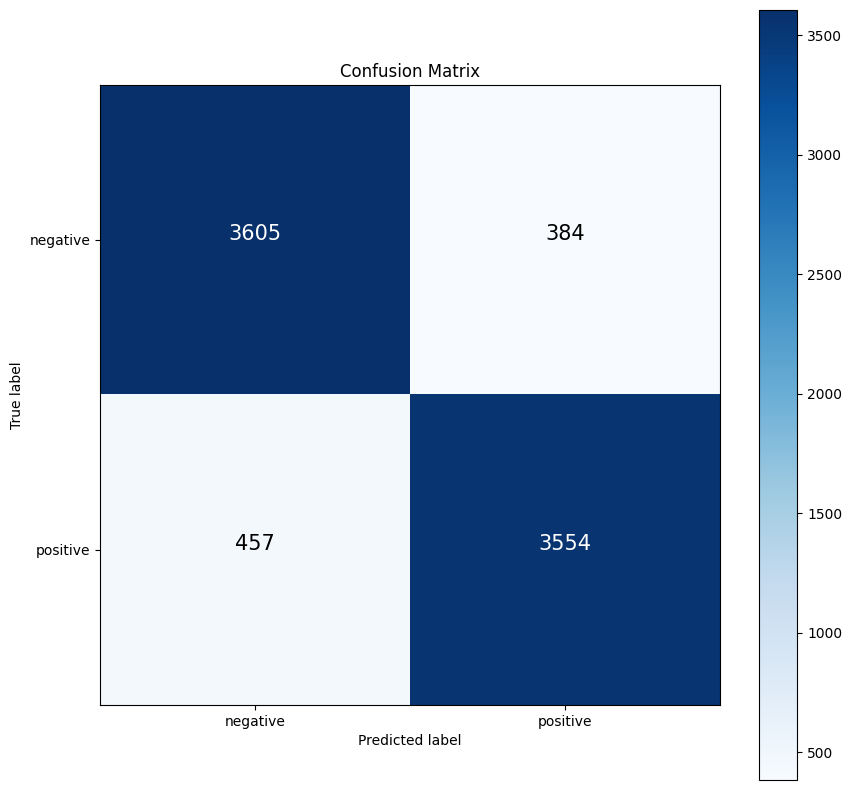

In [84]:
make_confusion_matrix(val_labels,model_0_preds,classes=["negative","positive"])

## Model 1: Logistic Regression

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Create a tokenization and modelling pipeline
model_1 = Pipeline([
    ("tfidf",TfidfVectorizer(ngram_range=(1,2), max_features=500000)),
    ("clf",LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1))
])

# Fit the pipeline to the training data
model_1.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=500000, ngram_range=(1, 2))),
                ('clf', LogisticRegression(C=2, max_iter=1000, n_jobs=-1))])

In [86]:
# Evaluate our logistic regression model
model_1_score = model_1.score(val_sentences,val_labels)
print(f"Our Logistic Regression model achieves an accuracy of: {model_1_score*100:.2f}%")

Our Logistic Regression model achieves an accuracy of: 89.96%


In [87]:
# Make predictiions
model_1_preds = model_1.predict(val_sentences)
model_1_preds[:10]

array([0, 1, 0, 1, 0, 0, 1, 1, 1, 0])

In [88]:
# Get baseline results
model_1_results = calculate_results(val_labels,model_1_preds)
model_1_results

{'accuracy': 0.899625,
 'precision': 0.8998631436117314,
 'recall': 0.899625,
 'f1-score': 0.8996062083241574}

### Confusion matrix for our Logistic Regressor model

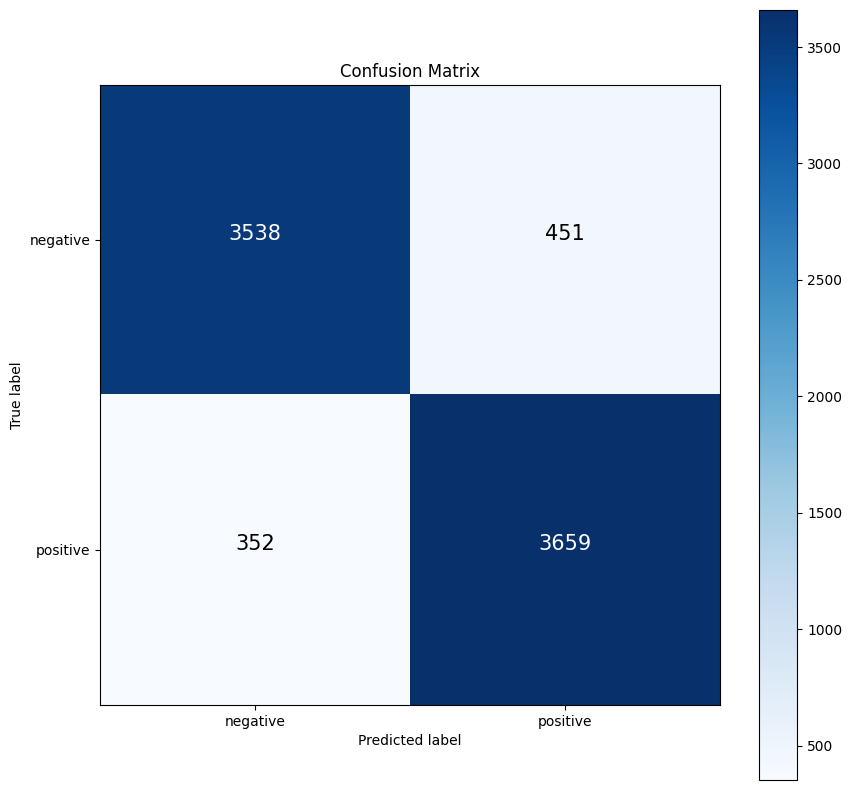

In [89]:
make_confusion_matrix(val_labels,model_1_preds,classes=["negative","positive"])

## Model 2: LSTM Model

### Creating text vectors and labels for the training of our LSTM model

In [90]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
max_features = len(words)
tokenizer_keras = Tokenizer(num_words=max_features, split=' ')
tokenizer_keras.fit_on_texts(new_data['text'].values)
X = tokenizer_keras.texts_to_sequences(new_data['text'].values)
X = pad_sequences(X)
y = np.asarray(new_data['label'])

In [91]:
X[:5],y[:5]

(array([[    0,     0,     0, ...,    85,  1949,  1016],
        [    0,     0,     0, ...,   485,     3,  3343],
        [    0,     0,     0, ...,   650, 13452,  4534],
        [    0,     0,     0, ...,   380,     1,  1455],
        [    0,     0,     0, ...,    33,  4092,  1468]], dtype=int32),
 array([1, 1, 1, 1, 1]))

### Creating an Embedding using an Embedding layer

In [92]:
from tensorflow.keras import layers
embed_dim = 128

embedding = layers.Embedding(input_dim = max_features,
                             output_dim = embed_dim,
                             input_length=X.shape[1])
embedding

### Splitting data into train and test format

In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20,
                                                    random_state =42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((32000, 1479), (8000, 1479), (32000,), (8000,))

In [94]:
# Creating a validation set
validation_size = 4000

X_validate = X_test[-validation_size:]
y_validate = y_test[-validation_size:]
X_test = X_test[:-validation_size]
y_test = y_test[:-validation_size]

In [95]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.optimizers import Adam
from keras.regularizers import L2
lstm_out = 196

model_2 = Sequential([
    Embedding(max_features, embed_dim,input_length = X.shape[1]),
    SpatialDropout1D(0.4),
    LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2),
    Dense(1,activation='sigmoid', kernel_regularizer=L2(0.001))
])


# Compiling the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1479, 128)         23844992  
                                                                 
 spatial_dropout1d (Spatial  (None, 1479, 128)         0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 1)                 197       
                                                                 
Total params: 24099989 (91.93 MB)
Trainable params: 24099989 (91.93 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [96]:
from keras import callbacks
# Creating an early stopping callback to restore the best state
earlystopping = callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)
model_2_history = model_2.fit(X_train, y_train, epochs = 20, batch_size=128, verbose = 1, validation_data=(X_validate, y_validate),
                    callbacks=[earlystopping])

Epoch 1/20
250/250 [==============================] - 851s 3s/step - loss: 0.4590 - accuracy: 0.7816 - val_loss: 0.2986 - val_accuracy: 0.8870
Epoch 2/20
250/250 [==============================] - 754s 3s/step - loss: 0.1980 - accuracy: 0.9279 - val_loss: 0.2994 - val_accuracy: 0.8765
Epoch 3/20
250/250 [==============================] - 745s 3s/step - loss: 0.1047 - accuracy: 0.9668 - val_loss: 0.3436 - val_accuracy: 0.8875
Epoch 4/20
250/250 [==============================] - 759s 3s/step - loss: 0.0557 - accuracy: 0.9839 - val_loss: 0.3737 - val_accuracy: 0.8763
Epoch 5/20
250/250 [==============================] - 737s 3s/step - loss: 0.0424 - accuracy: 0.9891 - val_loss: 0.4327 - val_accuracy: 0.8777
Epoch 6/20
250/250 [==============================] - 736s 3s/step - loss: 0.0356 - accuracy: 0.9911 - val_loss: 0.8050 - val_accuracy: 0.8685


In [97]:
# Make predictions
model_2_pred_probs = model_2.predict(X_test)
model_2_pred_probs[:10]

# Convert model 2 pred probs to labels format
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

125/125 [==============================] - 51s 407ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 0., 0., 0., 0., 1., 0., 1., 1.], dtype=float32)>

In [98]:
# Calculate model 2 results
model_2_results = calculate_results(y_test,model_2_preds)
model_2_results

{'accuracy': 0.88725,
 'precision': 0.8882121925093492,
 'recall': 0.88725,
 'f1-score': 0.8871864818285013}

### Plotting confusion matrix of LSTM model

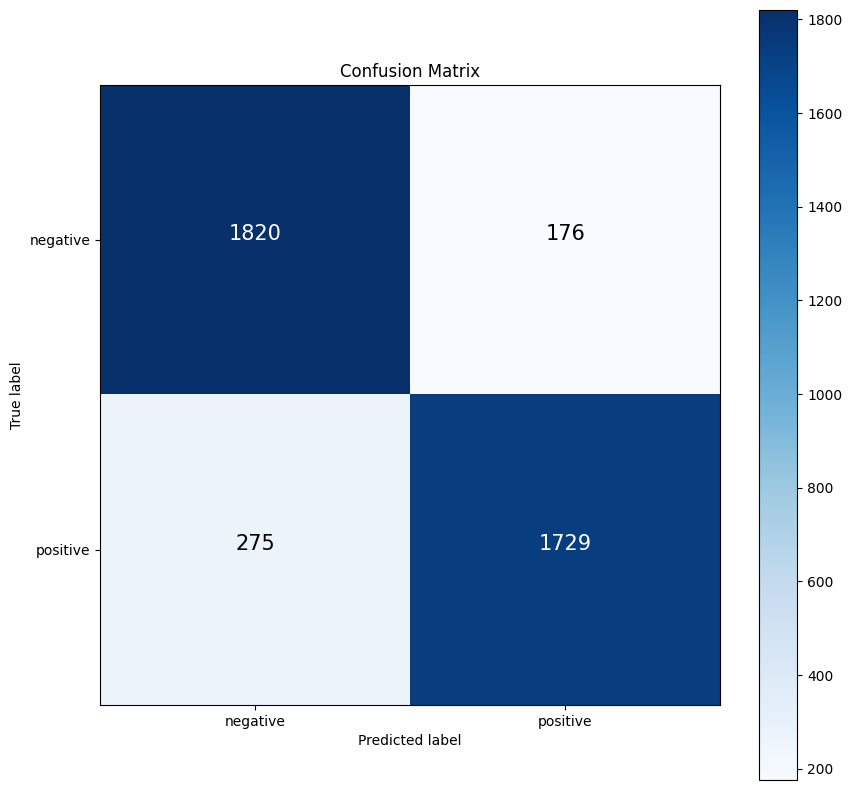

In [99]:
make_confusion_matrix(y_test,model_2_preds,classes=["negative","positive"])

### Creating a function to plot the separate loss curves for loss and accuracy

In [100]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();



### Plotting loss curves for our LSTM model

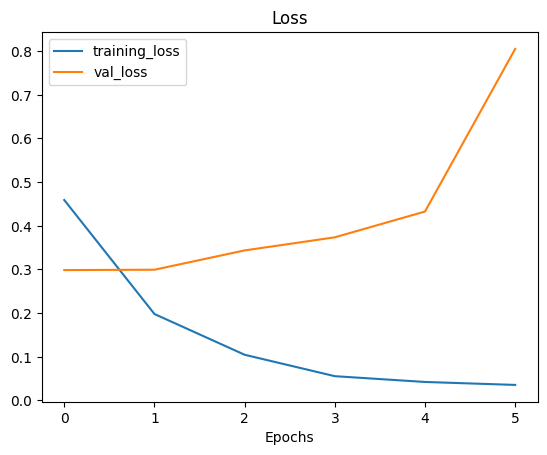

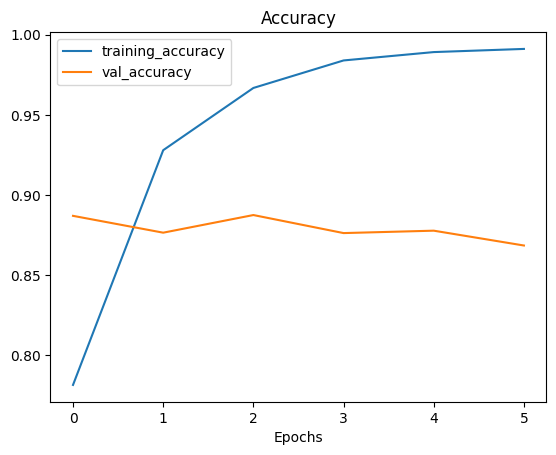

In [101]:
plot_loss_curves(model_2_history)

## Model 3: Using USE (Universal Sentence Encoder) through transfer learning

In [103]:
# Create a Keras layer for the universal sentence encoder
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow1/variations/large/versions/3",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="USE")

In [104]:
# Create a model for the sentence encoder
model_3 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid")
],name="model_3_USE")

# Compiling the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_3.summary()

Model: "model_3_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                32832     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 32897 (128.50 KB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [105]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  patience=3,
                                                  restore_best_weights=True)

In [106]:
# Creating a validation set
validation_size = 4000

X_validate = val_sentences[-validation_size:]
y_validate = val_labels[-validation_size:]
X_test = val_sentences[:-validation_size]
y_test = val_labels[:-validation_size]

In [107]:
# Train a classifier
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=10,
                              batch_size=128,
                              validation_data=(X_validate,y_validate),
                              callbacks=[early_stopping])

Epoch 1/10
250/250 [==============================] - 76s 280ms/step - loss: 0.4216 - accuracy: 0.8262 - val_loss: 0.3414 - val_accuracy: 0.8505
Epoch 2/10
250/250 [==============================] - 65s 262ms/step - loss: 0.3476 - accuracy: 0.8456 - val_loss: 0.3316 - val_accuracy: 0.8533
Epoch 3/10
250/250 [==============================] - 68s 273ms/step - loss: 0.3417 - accuracy: 0.8494 - val_loss: 0.3291 - val_accuracy: 0.8533
Epoch 4/10
250/250 [==============================] - 68s 273ms/step - loss: 0.3375 - accuracy: 0.8510 - val_loss: 0.3274 - val_accuracy: 0.8575
Epoch 5/10
250/250 [==============================] - 68s 273ms/step - loss: 0.3353 - accuracy: 0.8513 - val_loss: 0.3246 - val_accuracy: 0.8558
Epoch 6/10
250/250 [==============================] - 68s 273ms/step - loss: 0.3320 - accuracy: 0.8524 - val_loss: 0.3219 - val_accuracy: 0.8565
Epoch 7/10
250/250 [==============================] - 68s 273ms/step - loss: 0.3296 - accuracy: 0.8545 - val_loss: 0.3188 - val_ac

In [108]:
# Make predictions
model_3_pred_probs = model_3.predict(X_test)
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

125/125 [==============================] - 10s 69ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 0., 1., 0., 1., 1., 0., 1., 0.], dtype=float32)>

In [109]:
model_3_results = calculate_results(y_test,model_3_preds)
model_3_results

{'accuracy': 0.868,
 'precision': 0.8698461823055061,
 'recall': 0.868,
 'f1-score': 0.8678240275387263}

### Plotting the confusion matrix of model 3 (universal sentence encoder)

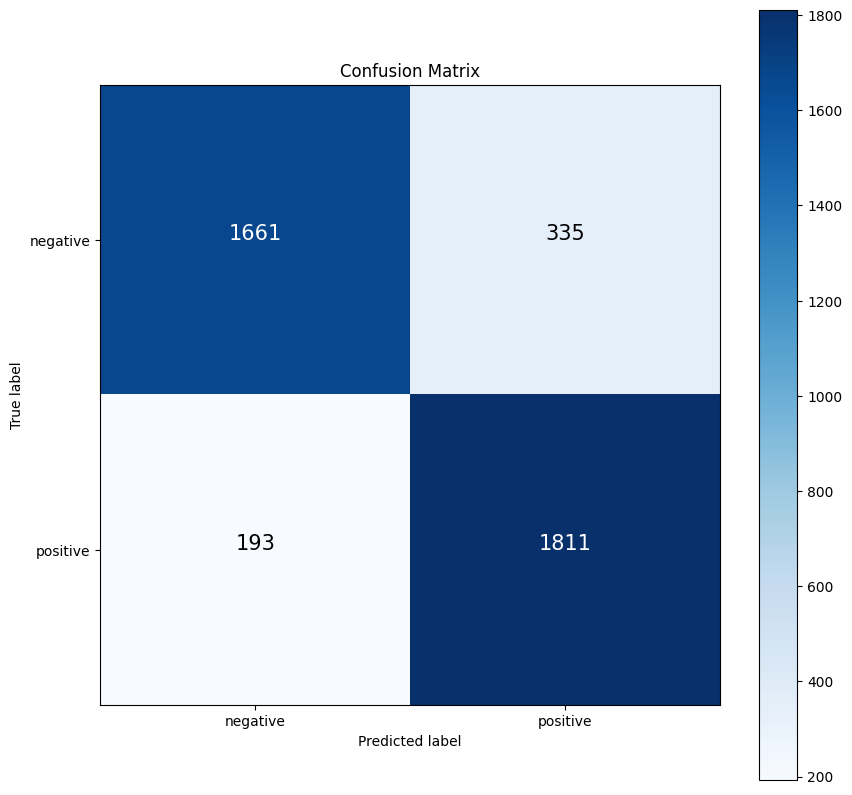

In [110]:
make_confusion_matrix(y_test,model_3_preds,classes=["negative","positive"])

### Plotting the loss curves of model 3

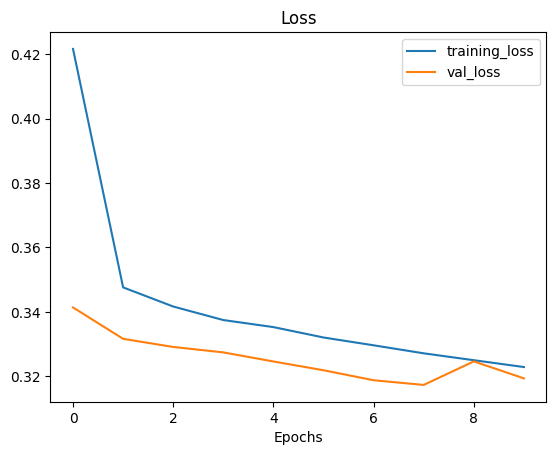

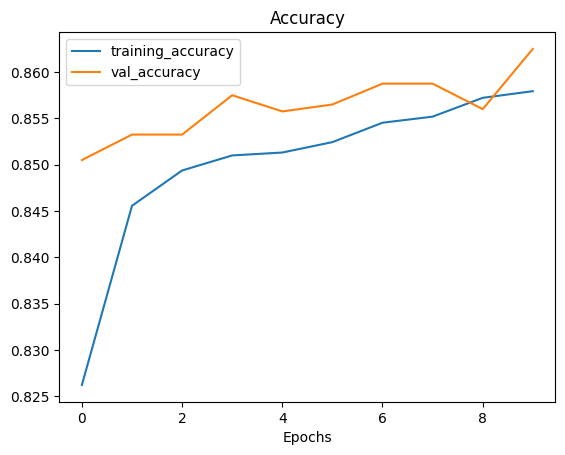

In [111]:
plot_loss_curves(model_3_history)

## Comparing all of our model results

In [112]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({"0_naive_bayes":model_0_results,
                                  "1_LogisticRegression":model_1_results,
                                  "2_lstm":model_2_results,
                                  "3_tf_hub_use_encoder":model_3_results})
all_model_results = all_model_results.transpose()

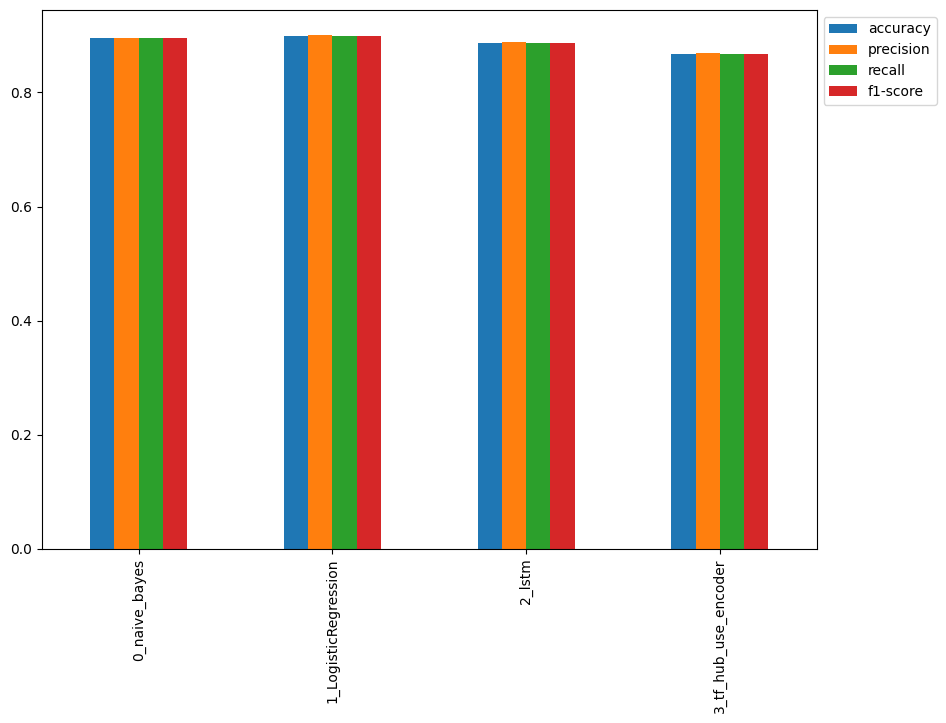

In [113]:
# PLot and comare all of the models
all_model_results.plot(kind="bar",figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0));

<Axes: >

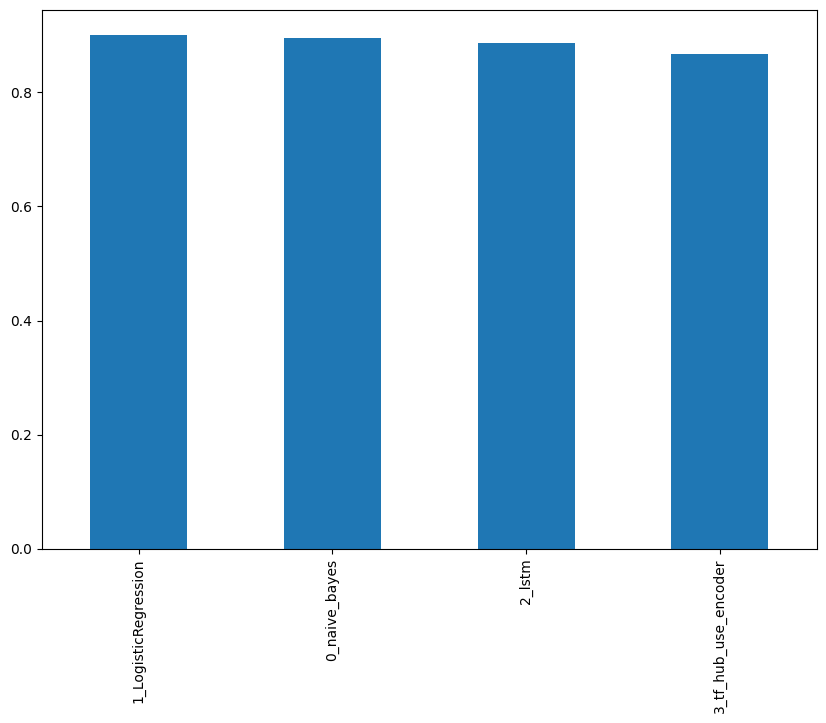

In [114]:
# Sort model results by f1-score
all_model_results.sort_values('f1-score',ascending=False)["f1-score"].plot(kind="bar",figsize=(10,7))

## Saving our best model

In [116]:
import joblib
pipeline_file = open("logistic_regression_sentiment_analysis.pkl","wb")
joblib.dump(model_1,pipeline_file)
pipeline_file.close()